In [1]:
import sys

from pishield.propositional_constraints.constraints_layer import ConstraintsLayer

sys.path.append('..')

import torch
from torch import nn
import matplotlib.pyplot as plt
from experiments.plotting import plotting_experiment_results

from shapes import Rectangle
from experiment import Experiment

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(2)

cpu


### Define the shapes

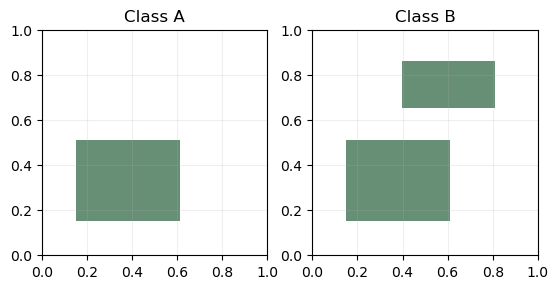

In [2]:
rectangle0 = Rectangle(0.15, 0.6, 0.15, 0.5)
rectangle1 = Rectangle(0.4, 0.8, 0.65, 0.85)
combined = rectangle0 | rectangle1
shapes = [rectangle0, combined]

fig, ax = plt.subplots(1, len(shapes))
ax[0].set_title("Class A")
ax[1].set_title("Class B")
ax[0].grid(alpha=0.2)
ax[1].grid(alpha=0.2)

for i, shape in enumerate(shapes):
  shape.plot(ax[i], full=True, cmap='Greens')
plt.show()

constraints_path = '../constraints/rectangles'

### Define the neural network

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.linear = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.linear(x)
        return x

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=2, bias=True)
    (3): Sigmoid()
  )
)


In [4]:
class PiShield_Experiment(Experiment):
    def __init__(self, name, model, shapes, constraints_path):
        super(PiShield_Experiment, self).__init__(name, model, shapes)

        # Build constraints layer & optimizer
        self.clayer = ConstraintsLayer(len(shapes), constraints_path)

    def train_step(self, device, ratio=1.):
        self.model.train()
        for batch, (X, y) in enumerate(self.train_dataloader):
            # Compute prediction error
            X, y = X.to(device), y.to(device)
            pred = self.model(X)
            constrained = self.clayer(pred, goal=y)
            
            loss = self.loss_fn(constrained, y)

            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()


### Train and test the model

In [5]:
experiment = PiShield_Experiment('rectangles', model, shapes, constraints_path)
experiment.run(400)
# experiment.save(dir='./models/')
trained_model = (model, experiment.clayer)

[] [<pishield.propositional_constraints.constraint.Constraint object at 0x7fade4877510>]
head 1 with old rules 1
head 1 with new rules 1
Generated 1 strata of constraints with None centrality
Epoch 1/400, Ratio 1.0
-----------------------
Created slicer for 1 modules (atoms {0, 1})
Test Error: 
 Accuracy: 84.3%, 23.7%
 Avg loss: 0.000236 
Created slicer for 1 modules (atoms {0, 1})
Test Error: 
 Accuracy: 84.3%, 76.3%
 Avg loss: 0.000201 

Created slicer for 1 modules (atoms {0, 1})
Test Error: 
 Accuracy: 84.3%, 76.3%
 Avg loss: 0.000200 

Created slicer for 1 modules (atoms {0, 1})
Test Error: 
 Accuracy: 84.3%, 76.3%
 Avg loss: 0.000213 

Created slicer for 1 modules (atoms {0, 1})
Test Error: 
 Accuracy: 84.3%, 76.3%
 Avg loss: 0.000210 

Created slicer for 1 modules (atoms {0, 1})
Test Error: 
 Accuracy: 84.3%, 76.3%
 Avg loss: 0.000197 

Created slicer for 1 modules (atoms {0, 1})
Test Error: 
 Accuracy: 84.3%, 76.3%
 Avg loss: 0.000191 

Created slicer for 1 modules (atoms {0, 1

In [6]:
# trained_model = load_trained_model('./models/rectangles-1.7814e-05-1707156305')  # model trained for 5000 epochs

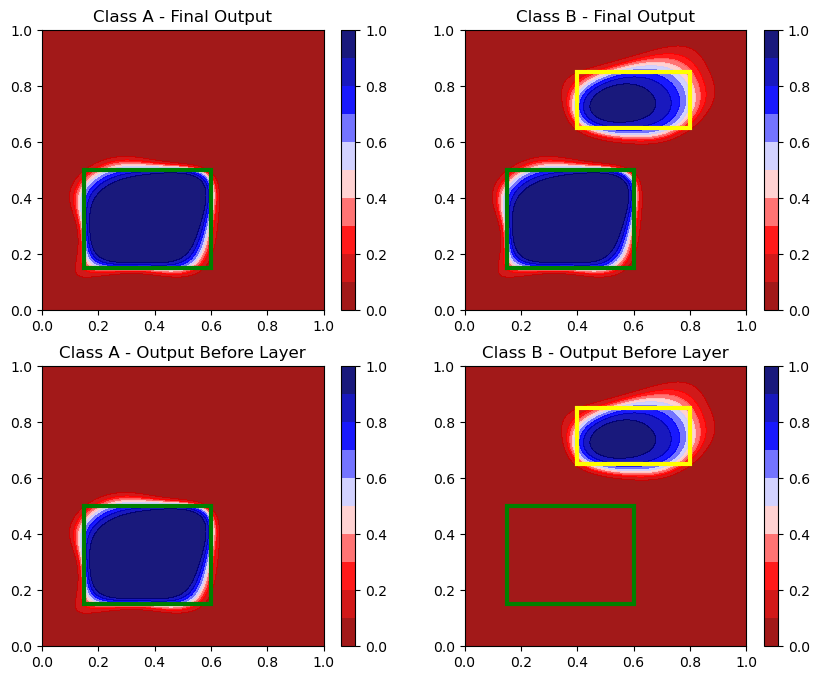

In [7]:
plotting_experiment_results(trained_model, rectangle0, rectangle1)
plt.show()

In [8]:
# Probably it would be good to have a "violations counter" (just to show that there are indeed no violations)
# And maybe see when you are creating the video, but it might be good to split the top row from the bottom row
# Also, I think you can train the network in real time, I tried with 20 neurons and 400 epochs and it trains almost instantly  